# Skin Cancer Detection with Machine Learning

## Introduction


### Goal
The goal is to classify skin cancer of different types with accuracy of at least 80%.


### Data
The Training Data consists of 10,000+ images and a metadata csv provided by [HAM10000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

### Model
The models built below with TensorFlow are Deep Learning models (neural networks).

## Setup

### Import Modules

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image

In [ ]:
print("GPU", "connected" if tf.config.list_physical_devices("GPU") else "not available")

GPU connected


### Import Data

In [ ]:
#!unzip "/content/drive/My Drive/SkinCancer/HAM10000_images_part_1.zip" -d "/content/drive/My Drive/SkinCancer/train_data"
#!unzip "/content/drive/My Drive/SkinCancer/HAM10000_images_part_2.zip" -d "/content/drive/My Drive/SkinCancer/train_data"

In [ ]:
metadata = pd.read_csv("drive/My Drive/SkinCancer/HAM10000_metadata.csv")

In [ ]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data Classification
The dx column in metadata describes the diagnoses of the following classes:

* Actinic keratoses and intraepithelial carcinoma / Bowen's disease **(akiec)** 
* basal cell carcinoma **(bcc)** 
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses) **(bkl)**
* dermatofibroma **(df)**
* melanoma **(mel)** 
* melanocytic nevi **(nv)**
* vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage) **(vasc)**


In [ ]:
np.unique(metadata["dx"])

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [ ]:
classnames = {'akiec': "Actinic keratoses", 
              'bcc': "basal cell carcinoma",
              'bkl': "benign keratosis-like", 
              'df': "dermatofibroma",
              'mel': "melanoma",
              'nv': "melanocytic nevi",
              'vasc': "vascular"}

## Data Visualisations and Engineering

### Metadata Visualisation

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


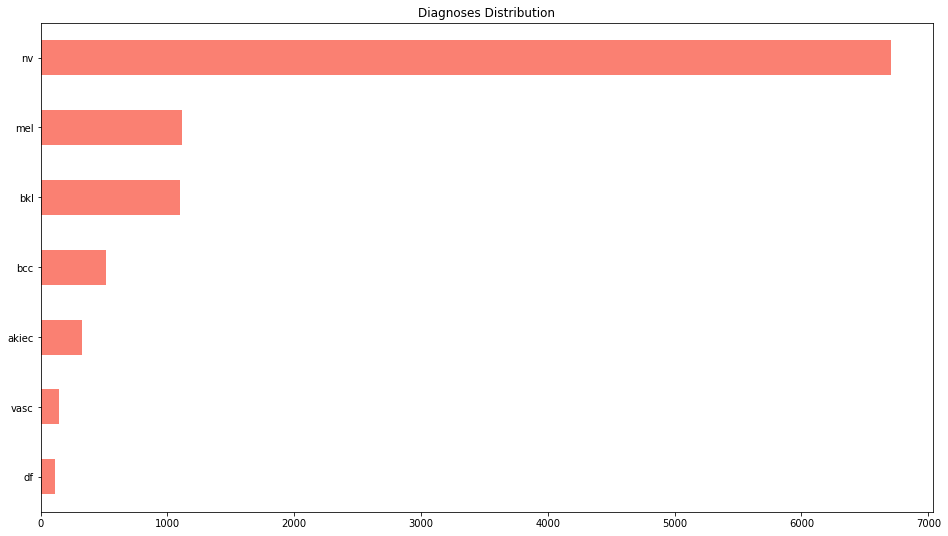

In [ ]:
metadata["dx"].value_counts().plot.barh(figsize=(16,9),
                                       title="Diagnoses Distribution",
                                       color=["salmon"]).invert_yaxis();
  

We can see that the Dataset is very unbalanced in the number of images of different categories. This might lead to problems regarding our model. We will use data augmentation to balance our data.

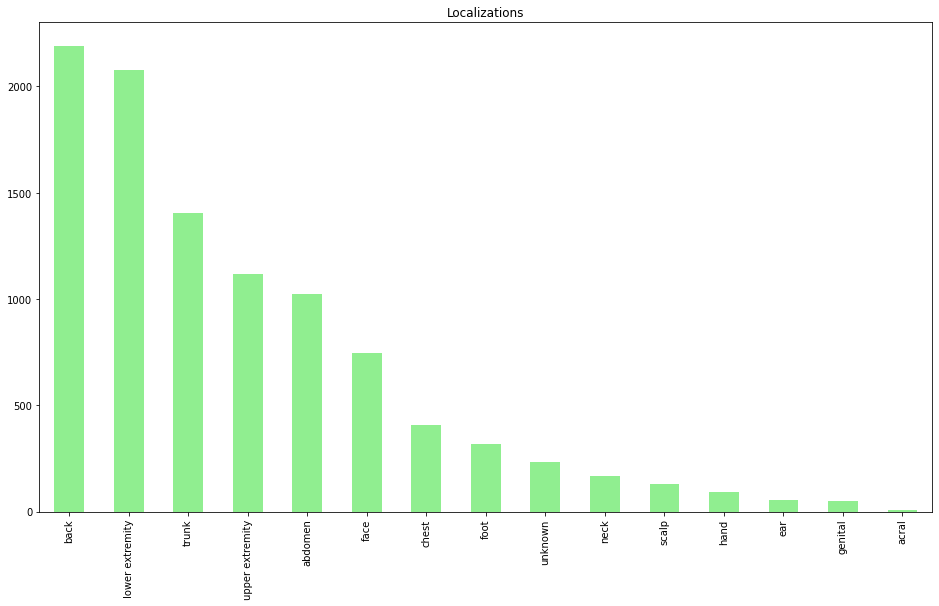

In [ ]:
metadata["localization"].value_counts().plot.bar(figsize=(16,9),
                                       title="Localizations",
                                       color=["lightgreen"]);

We could use this metadata to enhance our model. I choosed not to include the metadata, since I want the model to predict based only on the image data.

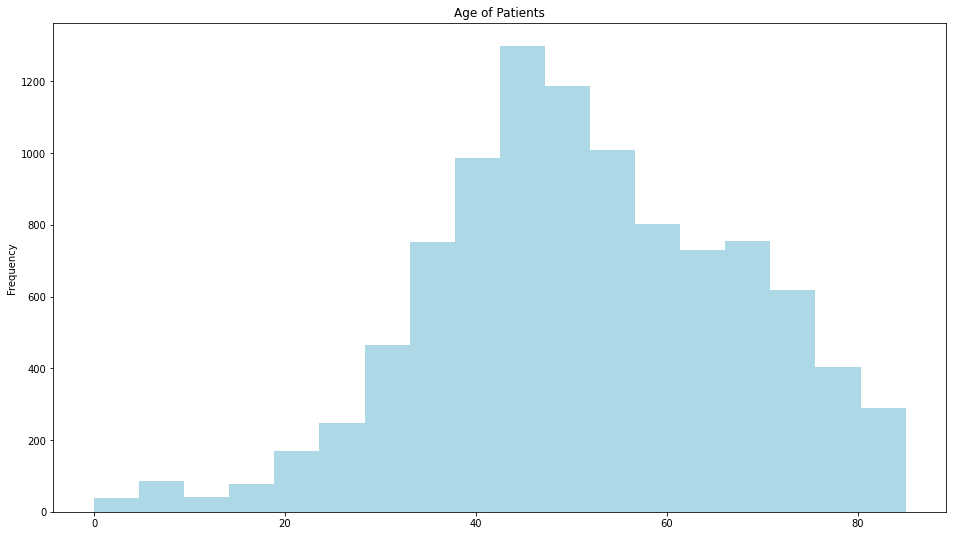

In [ ]:
metadata["age"].plot.hist(figsize=(16,9), 
                          bins=18,
                          title="Age of Patients",
                          color=["lightblue"]);

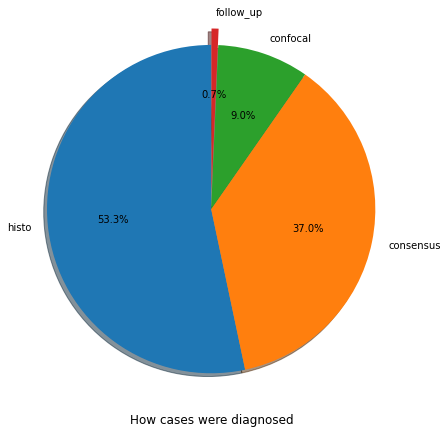

In [ ]:
pie_labels = metadata["dx_type"].unique()
relative_counts = metadata["dx_type"].value_counts()/len(metadata)
explode = (0, 0, 0, 0.1)
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(relative_counts, explode=explode, labels=pie_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("How cases were diagnosed", y=-0.1)
plt.show()

### Imagefiles and Label Data Engineering

In [ ]:
# check files number
print("Number of Images","match" if len(os.listdir("drive/My Drive/SkinCancer/train_data/")) == len(metadata) else "do not match", "length of metadata")


Number of Images match length of metadata


In [ ]:
# create pathnames from image ID's
img_filepaths= ["drive/My Drive/SkinCancer/train_data/" + fname + ".jpg" for fname in metadata["image_id"]]

In [ ]:
# create labels for images
labels = np.array(metadata["dx"])
classes = np.unique(labels)
classes, labels[:2]

(array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object),
 array(['bkl', 'bkl'], dtype=object))

In [ ]:
# create boolean array for each label
bool_labels = [label == classes for label in labels]
bool_labels[:2], bool_labels[0].argmax(), bool_labels[1].argmax()

([array([False, False,  True, False, False, False, False]),
  array([False, False,  True, False, False, False, False])],
 2,
 2)

### Train and Validation Data Split

In [ ]:
# training and validation split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

SIZE = 10015 #@param {type:"slider", min:1, max:10015}

X = img_filepaths
y = bool_labels

X, y = shuffle(X,y)

X = X[:SIZE]
y = y[:SIZE]

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.15,
                                                  random_state=42)

In [ ]:
len(X_train)

8512


### Training Data Balancing
Balance quantities of classes. Use data augmentation techniques while image preprocessing.


In [ ]:
def label_count(y, class_name):
  """Returns number of labels of a classname"""
  class_id = np.argmax([class_name == c for c in classes])
  count=0
  for label in y:
    if np.argmax(label) == class_id:
      count+=1
  return count

In [ ]:
# delete fraction of nv cases from training data to get a more balanced dataset
def delete_data(X, y, class_name, factor = 0.4):
  """
  Deletes fraction of Image, label pairs of a classname to handle data imbalances
  Factor 0.5 deletes half of the selected data.
  """
  class_id = np.argmax([class_name == c for c in classes])
  start = 0
  count = 0
  for num_delete in range (int(factor * label_count(y, class_name))):
    for i in range(start, len(y)):
      if np.argmax(y[i]) == class_id:
        del X[i]
        del y[i]
        count +=1
        start = i
        break
  print(f"Deleted {count} items of class {class_name}.")
  return X,y


In [ ]:
def copy_data(X, y, class_name, factor = 1):
  """
  Copies Image, label pairs of a classname with factor COPY to handle data imbalances.
  Factor COPY=1 doubles selected data.
  """
  class_id = np.argmax([class_name == c for c in classes])
  start = 0
  count = 0
  for num_copy in range (int(factor * label_count(y, class_name))):
    for i in range(start, len(y)):
      if np.argmax(y[i]) == class_id:
        X.append(X[i])
        y.append(y[i])
        count +=1
        start = i+1
        break
  print(f"Copied {count} items of class {class_name}.")
  return X,y

In [ ]:
def data_distribution(y, classes):
  """creates plot of data distribution"""
  counts = []
  for c in classes:
    counts.append(label_count(y, c))
  df = pd.DataFrame(data={'class': classes, 'count': counts}).sort_values(by=['count'])
  df.plot.barh(x='class', 
               y='count',
               figsize=(10,6),
               title="Data Distribution",
               color=["salmon"]);
  return None

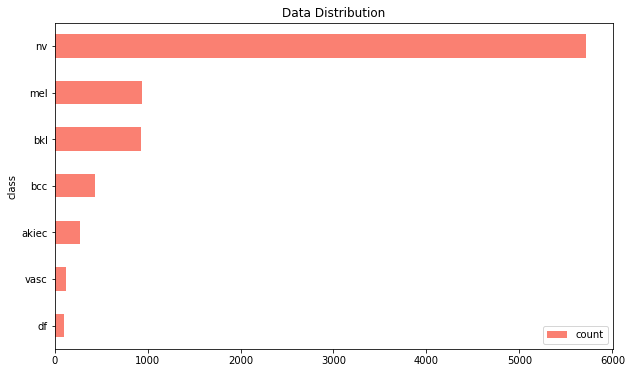

In [ ]:
data_distribution(y_train, classes)

In [ ]:
# delete half of nv cases
X_train, y_train = delete_data(X_train, y_train, "nv")
# increase mel and bkl cases by 50%
X_train, y_train = copy_data(X_train, y_train, "mel", 0.5)
X_train, y_train = copy_data(X_train, y_train, "bkl", 0.5)
# double bcc and akiec cases
X_train, y_train = copy_data(X_train, y_train, "bcc", 1)
X_train, y_train = copy_data(X_train, y_train, "akiec", 1)
# triple vasc and df cases
X_train, y_train = copy_data(X_train, y_train, "vasc", 2)
X_train, y_train = copy_data(X_train, y_train, "df", 2)

Deleted 2286 items of class nv.
Copied 472 items of class mel.
Copied 464 items of class bkl.
Copied 430 items of class bcc.
Copied 273 items of class akiec.
Copied 238 items of class vasc.
Copied 200 items of class df.


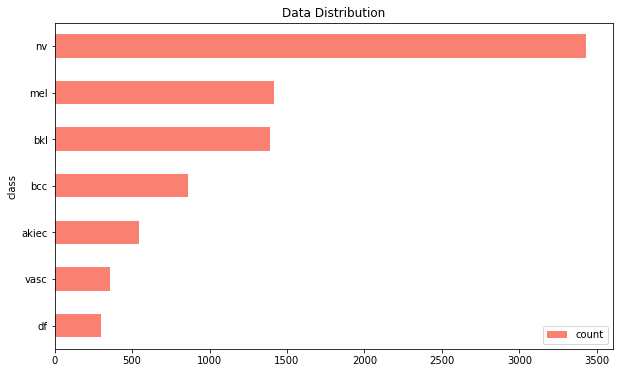

In [ ]:
data_distribution(y_train, classes)

### Image Preprocessing

In [ ]:
from matplotlib.pyplot import imread
image = imread(img_filepaths[7])
image.shape

(450, 600, 3)

In [ ]:
# preprocess image to tensor
IMG_SIZE = 224

def preprocess_img(img_filepath, transform=False):
  """Takes image and turns it into tensor"""
  # read img file
  image = tf.io.read_file(img_filepath)
  # turn img into tensor
  image = tf.image.decode_jpeg(image, channels=3)
  # convert colour channel
  image = tf.image.convert_image_dtype(image, tf.float32)
  # transform image
  if transform:
    image = tf.image.random_flip_left_right(image, seed=42)
    image = tf.image.random_flip_up_down(image, seed=42)
    image = tf.image.random_crop(image, [IMG_SIZE, IMG_SIZE, 3])
  # resize image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
def preprocessed_img_label_pair(img_filepath, label, transform=False):
  """Retruns tuple of preprocesed image and its label"""
  image = preprocess_img(img_filepath, transform)
  return image, label

### Image Batching
Batching is necessary since not all images fit into memory within one batch

In [ ]:
BATCH_SIZE = 32

def create_batches(X, y=None, valid_data=False, size=BATCH_SIZE):
  """Creates batches of X and y pairs. Shuffels train data"""
  if not y:   # no labels
    print("Created test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch =data.map(preprocess_img).batch(BATCH_SIZE) 

  elif valid_data:
    print("Created validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(preprocessed_img_label_pair).batch(BATCH_SIZE)

  else:
    print("Created training data batches")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(preprocessed_img_label_pair).batch(BATCH_SIZE)

  return data_batch

In [ ]:
# create training and validation batches
train_data = create_batches(X_train, y_train)
val_data = create_batches(X_val, y_val, valid_data=True)
train_data.element_spec

Created training data batches
Created validation data batches


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7), dtype=tf.bool, name=None))

### Image Viualisation

In [ ]:
def show_img(images, labels, num=20):
  """Displays 20 images and their label from a batch"""
  plt.figure(figsize=(10,10))

  # subplots of images with their labels
  for i in range(num):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(classnames[classes[labels[i].argmax()]])
    plt.axis("off")

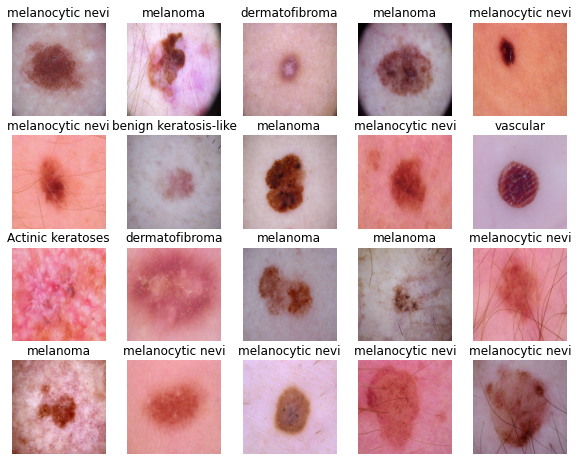

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_img(train_images, train_labels)

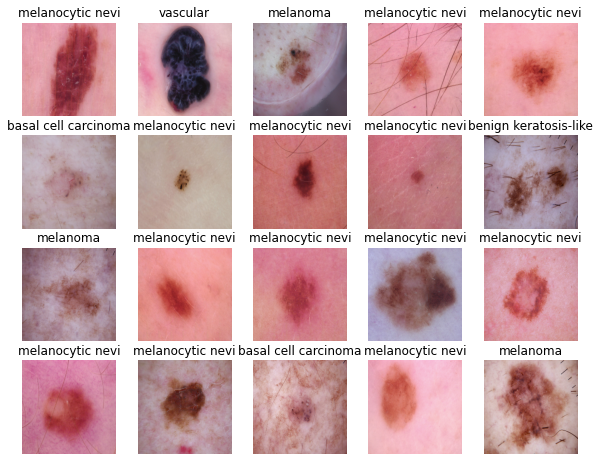

In [ ]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_img(val_images, val_labels)

## Building the Model

### Model 1 Creation (transfer model)

In [ ]:
# use of pretrained model from TensorFlow Hun
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(classes)

#MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
MODEL_URL = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  """Creates, compiles and builds the model. Needs input shape, output shape and model url."""
  print("Building model with:", model_url)

  # setup model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url, trainable=True), # input layer
    tf.keras.layers.Dense(units=output_shape, activation="softmax") # output layer
    ])
  
  # compile model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
      )
  
  # build model
  model.build(input_shape)
  
  return model

In [ ]:
# show a blank model 
model = create_model()
model.summary()

Building model with: https://tfhub.dev/tensorflow/resnet_50/classification/1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25612201  
_________________________________________________________________
dense (Dense)                (None, 7)                 7014      
Total params: 25,619,215
Trainable params: 25,566,095
Non-trainable params: 53,120
_________________________________________________________________


### Model 2 Creation (custom model)

In [ ]:
INPUT_SHAPE2 = (IMG_SIZE, IMG_SIZE, 3)
OUTPUT_SHAPE = len(classes)

In [ ]:
def create_custom_model(input_shape=INPUT_SHAPE2, output_shape=OUTPUT_SHAPE):
    """
    Returns a compiled convolutional neural network model. 
    """
    model = tf.keras.models.Sequential([
        # convolution layer on input (images)
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=input_shape
        ),

        # max - pooling layer, 2x2 pool
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # new convolution
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu"),
        
        # new pooling
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # new convolution
        tf.keras.layers.Conv2D(
            64, (3, 3), activation="relu"),

        # new pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # flatten units
        tf.keras.layers.Flatten(),

        # hidden layer with dropout
        tf.keras.layers.Dense(128, activation="relu"),

        # dropout layer 
        tf.keras.layers.Dropout(0.5),

        # output layer
        tf.keras.layers.Dense(output_shape, activation="softmax")
    ])

    # compile model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# show a blank model 
custom_model = create_custom_model()
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)               

### Callbacks

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
def create_tensorboard_callback():
  logdir = os.path.join("drive/My Drive/SkinCancer/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# early stopping
PATIENCE = 25 #@param {type:"slider", min:2, max:100}
early_stopping = tf.keras.callbacks.EarlyStopping(
                 monitor="val_accuracy", patience=100)

## Training the model

In [ ]:
NUM_EPOCHS = 50 #@param {type:"slider", min:10, max:100}

In [ ]:
# function to train the model
def train_model(custom=False):
  """
  returns trained model
  """
  if custom:
    model = create_custom_model()
  else:
    model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data, 
            epochs=NUM_EPOCHS, 
            validation_data=val_data, 
            validation_freq=1, 
            callbacks=[tensorboard, early_stopping])
  return model

In [ ]:
def save_model(model, suffix=None):
  modeldir  = os.path.join("drive/My Drive/SkinCancer/trained_models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "_" + suffix + ".h5"
  model.save(model_path)
  print(f"Model saved to: {model_path}")
  return model_path

In [ ]:
# traning
#model = train_model(custom=False)

In [ ]:
# save model
#save_model(model, suffix="resnet")

In [ ]:
%tensorboard --logdir drive/My\ Drive/SkinCancer/logs

UsageError: Line magic function `%tensorboard` not found.


##Loading a trianed model


In [ ]:
# load model
def load_model(filepath, custom=False):
  """Loads a trained model"""
  if custom:
    model = tf.keras.models.load_model(filepath)
  else:
    model = tf.keras.models.load_model(filepath, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# execute load model function
model = load_model("/content/drive/My Drive/SkinCancer/trained_models/20201017-152527_custom_images.h5")

In [ ]:
# export tfjs model of loaded model

#!pip install -q tensorflowjs

import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "drive/My Drive/SkinCancer/trained_models")

ModuleNotFoundError: ignored

In [ ]:
# export tflite model of loaded model

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('scc_model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmps5_8w78f/assets


INFO:tensorflow:Assets written to: /tmp/tmps5_8w78f/assets


## Evaluation and Prediction

### Create Validation Predictions

In [ ]:
model.evaluate(val_data)

47/47 [==============================] - 939s 20s/step - loss: 0.4236 - accuracy: 0.8417


[0.42362162470817566, 0.8416500091552734]

In [ ]:
# create predictions
val_predictions = model.predict(val_data, verbose=1)
val_predictions.shape, sum(val_predictions[0])

47/47 [==============================] - 12s 243ms/step


((1503, 7), 1.000000010069038)

In [ ]:
def prediction_label(prediction, print=False):
  """Prints label with highest probability for prediction array"""
  max_index = prediction.argmax()
  label = classes[max_index]
  if print:
    print(f"Predicted label: {label} with {prediction[max_index]}")
  
  return label

In [ ]:
# unbatch data for visualisations
def breakup_batches(data):
  """Return seperate lists of images and labels"""
  images = []
  labels = []

  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(classes[np.argmax(label)])
  return images, labels


In [ ]:
val_images, val_labels = breakup_batches(val_data)

### Validation Data Visualisation

In [ ]:
def plot_prediction(predictions_probs, true_labels, images, n=1):
  """View the prediction """
  pred_prob, true_label, image = predictions_probs[n], true_labels[n], images[n]

  pred_label = prediction_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("Pred: {} {:2.0f}%, True: {}".format(classnames[pred_label],
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)

In [ ]:
def top_preds(prediction_probs, labels, n=1):
  """top 10 highest preds"""
  pred_prob, true_label = prediction_probs[n], labels[n]

  pred_label = prediction_label(pred_prob)
  top_indexes = pred_prob.argsort()[-10:][::-1]
  top_preds = pred_prob[top_indexes]
  top_labels = classes[top_indexes]

  top_plot = plt.bar(np.arange(len(top_labels)),
                               top_preds,
                               color = "grey")
  plt.xticks(np.arange(len(top_labels)),
             labels=top_labels,
             rotation ="vertical")
  if np.isin(true_label, top_labels):
    top_plot[np.argmax(top_labels == true_label)].set_color("green")

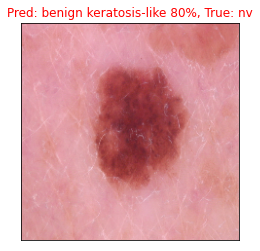

In [ ]:
plot_prediction(val_predictions, val_labels, val_images, 23)

In [ ]:
def plot_predicion_distributions(predicions, true_labels, images, i_start=0):
  """Plots multiple image, prediction distribution pairs. Starts Data at i_start"""
  rows = 3
  cols = 2
  num_img = rows*cols
  plt.figure(figsize=(10*cols, 5*rows))
  for i in range(num_img):
    plt.subplot(rows, 2*cols, 2*i+1)
    plot_prediction(predicions, true_labels, images, n=i+i_start)
    plt.subplot(rows, 2*cols, 2*i+2)
    top_preds(predicions, true_labels, i+i_start)
  plt.tight_layout()
  plt.show()

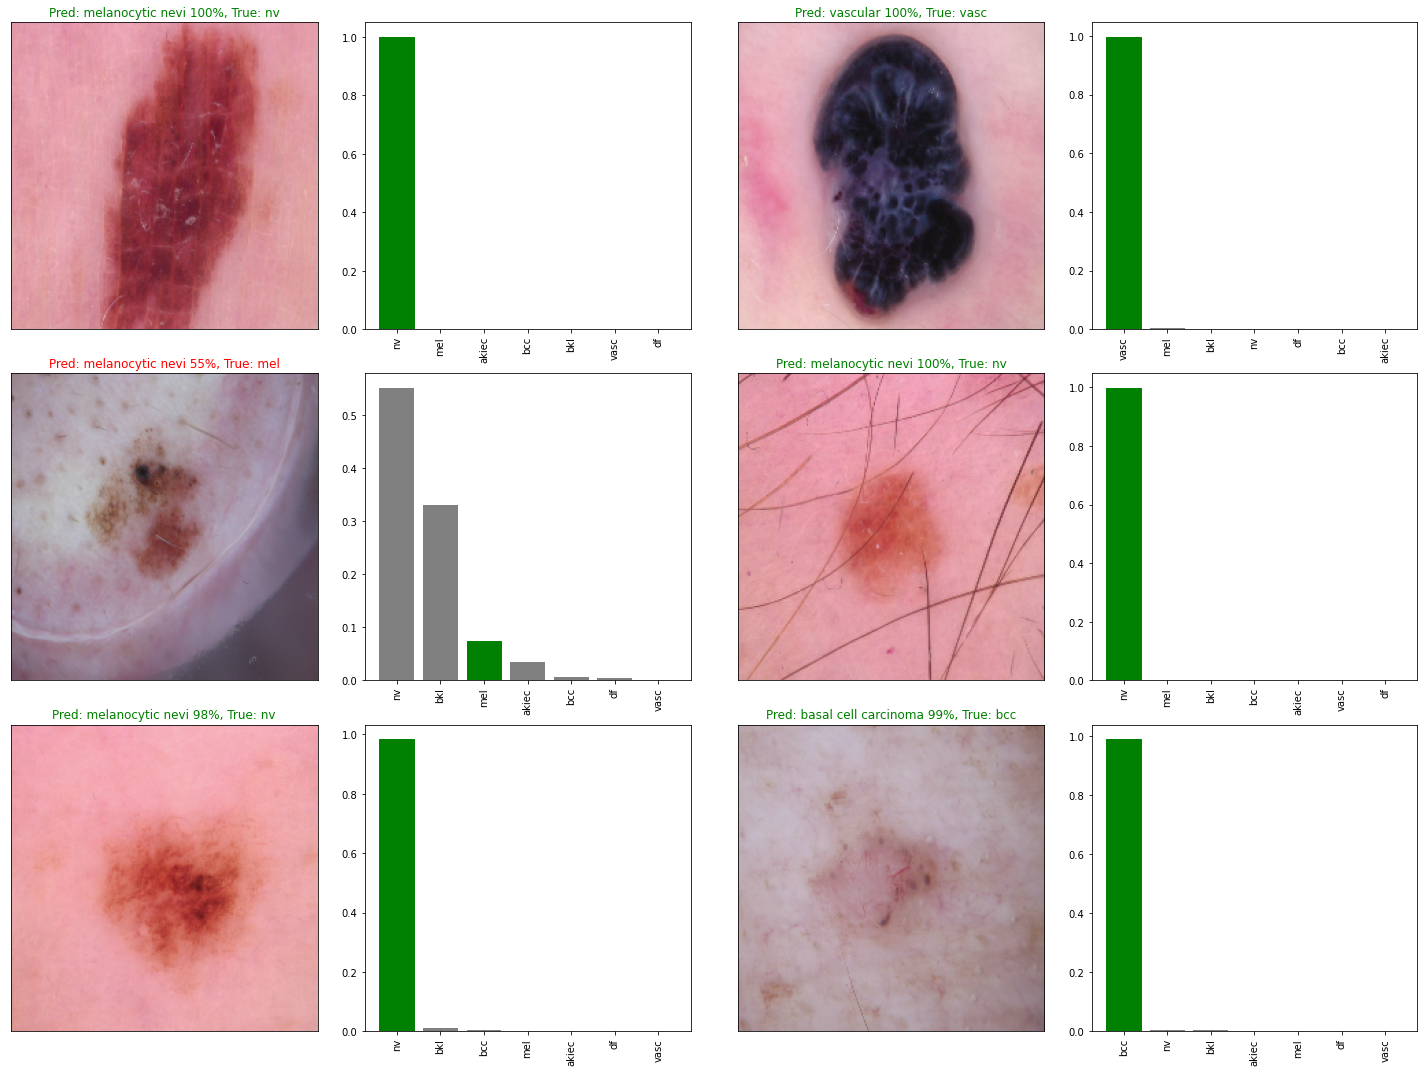

In [ ]:
plot_predicion_distributions(val_predictions, val_labels, val_images)

### Confusion Matrix

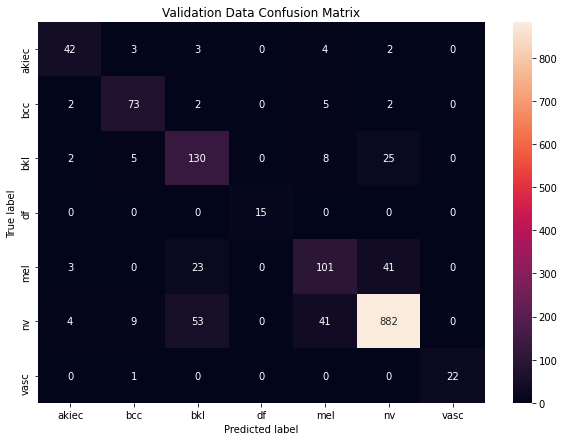

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
val_prediction_labels = [prediction_label(prediction) for prediction in val_predictions]
cm = confusion_matrix(y_true=val_labels, y_pred=val_prediction_labels)
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True,  fmt="d")
plt.title("Validation Data Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


### Create Test Predictions

In [ ]:
#!unzip "/content/drive/My Drive/SkinCancer/ISIC2018_Task3_Test_Input.zip" -d "/content/drive/My Drive/SkinCancer/test_data"

In [ ]:
# load test image files
test_path = "drive/My Drive/SkinCancer/test_data/"
test_filenames = [test_path +fname for fname in os.listdir(test_path)]
test_filenames[:5]

['drive/My Drive/SkinCancer/test_data/ISIC_0035603.jpg',
 'drive/My Drive/SkinCancer/test_data/ISIC_0035602.jpg',
 'drive/My Drive/SkinCancer/test_data/ISIC_0035608.jpg',
 'drive/My Drive/SkinCancer/test_data/ISIC_0035605.jpg',
 'drive/My Drive/SkinCancer/test_data/ISIC_0035600.jpg']

In [ ]:
# create test data batches
test_data = create_batches(test_filenames)

Created test data batches


In [ ]:
# make test predictions
test_predictions = model.predict(test_data, verbose=1)

 1/48 [..............................] - ETA: 16:36

KeyboardInterrupt: ignored

In [ ]:
test_predictions[0]

### Visualize Test predictions

In [ ]:
def plot_test_predictions(predicted_labels, predictions, images):
  """Plots images and their predicted labels"""
  i_start = 90
  rows = 3
  cols = 10
  num_img = rows*cols
  plt.figure(figsize=(2*cols, 2.5*rows))
  for i in range(num_img):
    plt.subplot(rows, cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("{} {:2.0f}%".format(predicted_labels[i],
                                  np.max(predictions[i])*100))
    plt.imshow(images[i])
  plt.show()

In [ ]:
# get test prediction labels
test_labels = [prediction_label(test_predictions[i]) for i in range(len(test_predictions))]

In [ ]:
# get test images
test_images = []
for image in test_data.unbatch().as_numpy_iterator():
  test_images.append(image)

In [ ]:
plot_test_predictions(test_labels, test_predictions, test_images)

In [ ]:
# create "test" as truth labels
test_truth = ["test" for i in range(len(test_predictions))]

In [ ]:
plot_predicion_distributions(test_predictions, test_truth, test_images)

### Save test predictions

In [ ]:
# generate prediction csv
pd.options.display.float_format = '{:.4f}'.format
test_preds = pd.DataFrame(test_predictions)
test_preds.columns = classes
test_preds.insert(0, 'IMG_ID', [os.path.splitext(path)[0] for path in os.listdir(test_path)])
test_preds.head()

In [ ]:
# save prediction csv
test_preds.to_csv("drive/My Drive/SkinCancer/test_predictions.csv")

### Custom Data Predictions

In [ ]:
# get filenames
custom_path = "drive/My Drive/SkinCancer/custom_data/"
custom_filenames = [custom_path +fname for fname in os.listdir(custom_path)]
custom_filenames

In [ ]:
# batch data
custom_data = create_batches(custom_filenames)

In [ ]:
# predictions
custom_predictions = model.predict(custom_data)
custom_predictions[0]

In [ ]:
# prediction labels
custom_labels = [prediction_label(custom_predictions[i]) for i in range(len(custom_predictions))]

In [ ]:
# create "custom" as truth labels
custom_truth = ["custom" for i in range(len(test_predictions))]

In [ ]:
# get images
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
plot_test_predictions(custom_labels, custom_predictions, custom_images)

In [ ]:
plot_predicion_distributions(custom_predictions, custom_truth, custom_images)